Rough outline for cleaning:
1. See what is available
2. shrink memory footprint 
    by casting columns to different data types: 
        a. text to category where appropriate, 
        b. timestamp string to pandas datetimestamp).
3. look for outliers/bad data and drop rows that don't make sense

In [1]:
#import dependencies
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns  #using for histograms to clean data

In [33]:
def humanbytes(B):  #https://stackoverflow.com/questions/12523586/python-format-size-application-converting-b-to-kb-mb-gb-tb
   'Return the given bytes as a human friendly KB, MB, GB, or TB string'
   B = float(B)
   KB = float(1024)
   MB = float(KB ** 2) # 1,048,576
   GB = float(KB ** 3) # 1,073,741,824
   TB = float(KB ** 4) # 1,099,511,627,776

   if B < KB:
      return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
   elif KB <= B < MB:
      return '{0:.2f} KB'.format(B/KB)
   elif MB <= B < GB:
      return '{0:.2f} MB'.format(B/MB)
   elif GB <= B < TB:
      return '{0:.2f} GB'.format(B/GB)
   elif TB <= B:
      return '{0:.2f} TB'.format(B/TB);
    


In [36]:
def df_memory_total (df):     #takes dataframe as input.
    s=df.memory_usage()       #generate series to call sum() next
    t=s.sum()                 #getting the total of all memory components
    return(humanbytes(t))     #format the total in terms of KB, MB, etc.


In [2]:
#Exploring the most recent data file to get a basis of comparison

df = pd.read_csv('../DataDump/202104-citibike-tripdata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016151 entries, 0 to 2016150
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         int64  
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           int64  
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  birth year               int64  
 14  gender                   int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 230.7+ MB


In [3]:
df.describe().round(2)

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,2016151.00,2016151.00,2016151.00,2016151.00,2016151.00,2016151.00,2016151.00,2016151.00,2016151.00,2016151.00
mean,1186.04,2286.18,40.74,-73.98,2281.80,40.74,-73.98,43815.73,1970.34,0.06
std,11810.93,1591.52,0.04,0.02,1592.29,0.04,0.02,9489.69,3.35,0.29
min,61.00,72.00,40.63,-74.03,72.00,40.63,-74.08,14529.00,1888.00,0.00
25%,386.00,450.00,40.72,-73.99,448.00,40.72,-73.99,37403.00,1970.00,0.00
50%,689.00,3154.00,40.74,-73.98,3152.00,40.74,-73.98,47415.00,1970.00,0.00
75%,1223.00,3641.00,40.77,-73.96,3641.00,40.77,-73.96,51104.00,1970.00,0.00
max,2899719.00,4502.00,40.87,-73.88,4519.00,40.87,-73.88,55627.00,2004.00,2.00


### Observations:
 * one month of data takes up ~ 0.25 GB, which is huge. 
 * We won't be able to look at too many files unless we shrink the footprint
 * Cardinality (relative count of distinct values) is much lower for station ID, suggesting breaking out this info,
     ** - problem encountered: I cannot assume the same set of stations is in each file, so it would be necessary to pull all distinct values... Therefore, trying another approach as outlined here: https://towardsdatascience.com/exploring-bike-share-data-3e3b2f28760c

In [4]:
#borrowed from blog posting referenced above: 

pd.DataFrame.from_records([(col, df[col].nunique(), df[col].dtype, df[col].memory_usage(deep=True) )  for col in df.columns],
  columns=['Column Name', 'Unique', 'Data Type','Memory Usage'])

,Column Name,Unique,Data Type,Memory Usage
0,tripduration,14311,int64,16129336
1,starttime,2014805,object,163308359
2,stoptime,2014800,object,163308359
3,start station id,1391,int64,16129336
4,start station name,1391,object,155144060
5,start station latitude,1391,float64,16129336
6,start station longitude,1388,float64,16129336
7,end station id,1402,int64,16129336
8,end station name,1402,object,155140885
9,end station latitude,1402,float64,16129336


In [5]:
#Changing times stored as strings to timestamp
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

In [6]:
#Applying 'category' data type to string columns

category_columns = ['start station name', 'end station name', 'bikeid', 'usertype', 'gender']
for col in category_columns:
    df[col] = df[col].astype('category')
    

In [7]:
#Since we have trip duration and start time, we can drop stoptime
df = df.drop('stoptime', axis = 1)

In [8]:
#Checking memory footprint again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016151 entries, 0 to 2016150
Data columns (total 14 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   start station id         int64         
 3   start station name       category      
 4   start station latitude   float64       
 5   start station longitude  float64       
 6   end station id           int64         
 7   end station name         category      
 8   end station latitude     float64       
 9   end station longitude    float64       
 10  bikeid                   category      
 11  usertype                 category      
 12  birth year               int64         
 13  gender                   category      
dtypes: category(5), datetime64[ns](1), float64(4), int64(4)
memory usage: 154.7 MB


<Figure size 432x288 with 0 Axes>

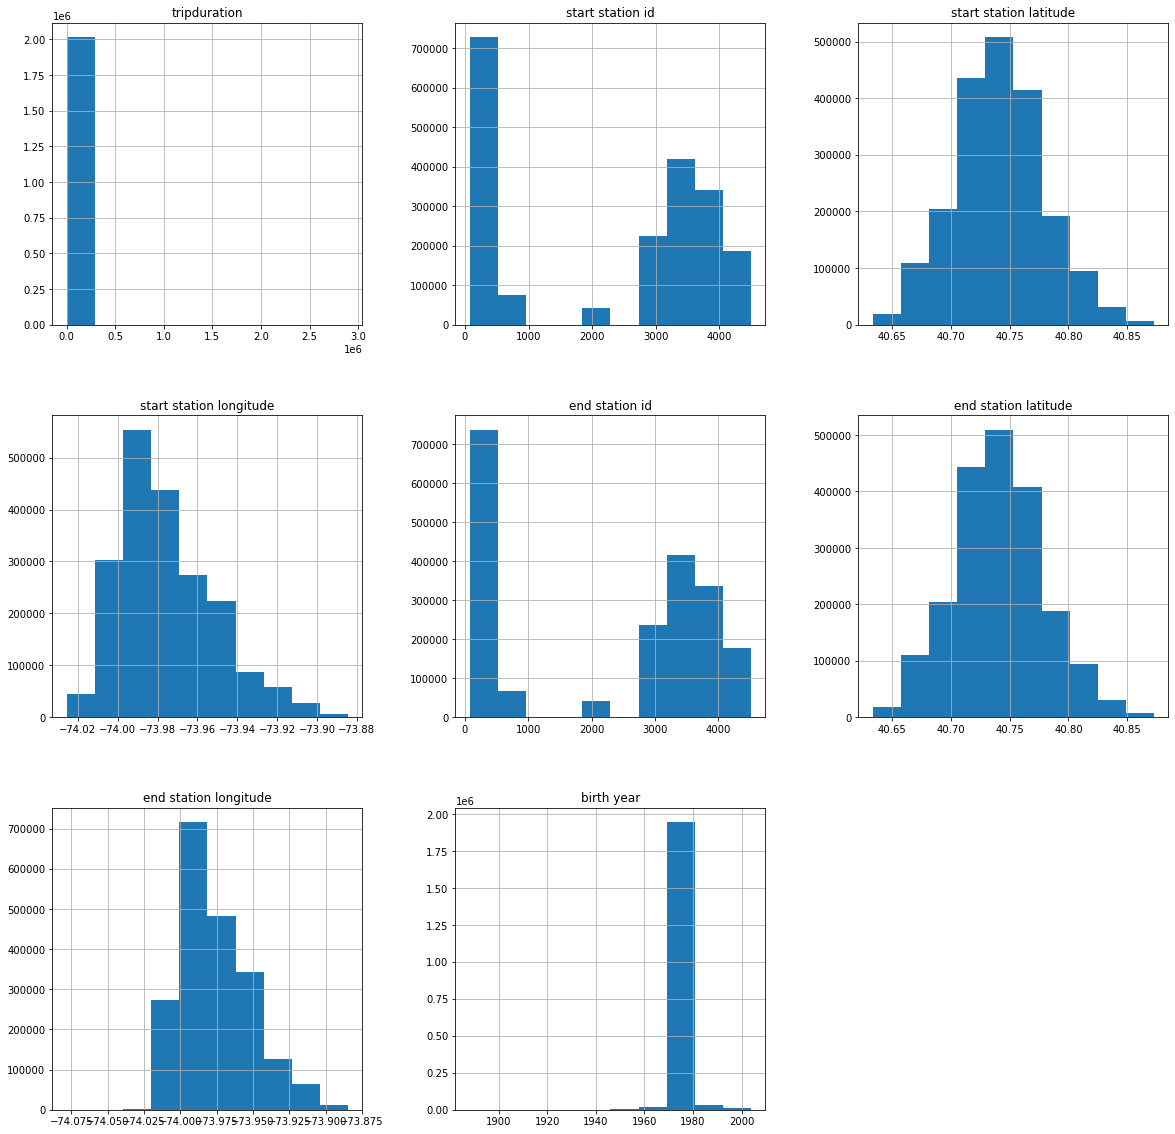

In [9]:
# Build histograms to profile data fields
fig=plt.figure()
df.hist(figsize=(20,20))
plt.show()

### Histograms Observations
* start/end station data look good, showing symmetry between the distributions for lat, lon, & station ID.
* birth year and trip duration are extremely skewed. These two will have to be explored further. 


In [10]:
df['birth year'].value_counts()

1970    1926868
1990       3350
1992       2819
1989       2797
1991       2705
         ...   
1921          1
1900          1
1899          1
1893          1
1890          1
Name: birth year, Length: 83, dtype: int64

In [39]:
x = 1926868/2016150
y = 2016150 - 1926868

print(f'the year 1970 takes up {x: .0%} of all the birth year values. \n {y: ,} trips remain, but relative to the total, \n I feel the column should be disregarded.')


the year 1970 takes up  96% of all the birth year values. 
  89,282 trips remain, but relative to the total, 
 I feel the column should be disregarded.


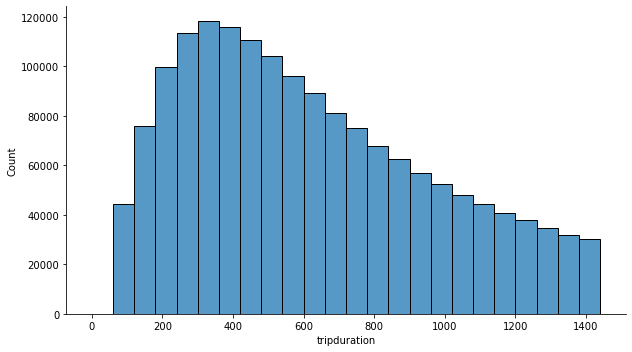

In [12]:
sns.displot(data=df, x="tripduration" , bins=range(0,1500,60),  aspect=16/9)

Skewness of tripduration appears to be okay. Most values are near 5 minutes, and then slowly trail off from there. This makes sense as most trips would be expected to be in the neighborhood of 5-10 minutes. Keeping data.

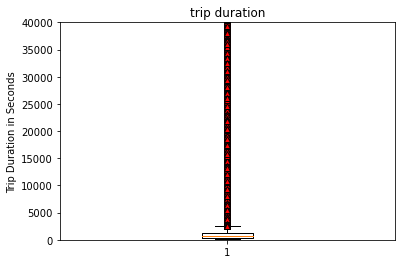

In [13]:
fig1, ax1 = plt.subplots()
ax1.set_title('trip duration')
ax1.boxplot(df['tripduration'], flierprops = dict(markerfacecolor='red', marker='^'))
# ax1.set_xticklabels(treatments)
ax1.set_ylabel('Trip Duration in Seconds')
ax1.set_ylim(0, 40000)
plt.show()

### Boxplot interpretation:
* trip duration shows a fairly compact box, with a large number of outliers that have very large magnitude compared to the majority of data points. This will shift the average upward, and it would be better to drop those rows. 

In [14]:
    
    # Determine outliers using upper and lower bounds
        #Perform necessary calculations to get outlier bounds
    quartiles = df['tripduration'].quantile([.25,.5,.75]) 
    lowerq = quartiles[0.25]                           
    upperq = quartiles[0.75]                           
    iqr = upperq-lowerq                                
    lower_bound = lowerq - (1.5*iqr)                   
    upper_bound = upperq + (1.5*iqr)                   
    
    #Loop over set to find any outliers
    outliers = []   #initialize empty list to trap any outliers
    for measurement in df['tripduration']:
        if (measurement > upper_bound):  # not trapping small outliers, only want the points greater than upper_bound
            outliers.append(measurement)

In [15]:
num = len(outliers)
den = len(df['tripduration'])

print(f'There are {num} out of {den} outliers, or {num/den:.0%}. These records will be excluded from analysis')

There are 107223 out of 2016151 outliers, or 5%. These records will be excluded from analysis


In [16]:
len(df['tripduration'])

2016151

In [17]:
df1 = df[df['tripduration']<upper_bound]  #Filtering such that outliers are dropped. Outliers are defined as tripduration > upper_bound

In [18]:
len(df1)

1908928

In [42]:
df1a = df1.drop('birth year', axis=1)

In [43]:
df1a.describe().round(2)

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude
count,1908928.00,1908928.00,1908928.00,1908928.00,1908928.00,1908928.00,1908928.00
mean,800.13,2271.81,40.74,-73.98,2266.55,40.74,-73.98
std,549.60,1592.31,0.04,0.02,1593.06,0.04,0.02
min,61.00,72.00,40.63,-74.03,72.00,40.63,-74.04
25%,373.00,448.00,40.72,-73.99,447.00,40.72,-73.99
50%,650.00,3148.00,40.74,-73.98,3147.00,40.74,-73.98
75%,1106.00,3641.00,40.77,-73.96,3637.00,40.76,-73.96
max,2478.00,4502.00,40.87,-73.88,4502.00,40.87,-73.88


In [44]:
df_memory_total(df1a)

'146.55 MB'

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016151 entries, 0 to 2016150
Data columns (total 14 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   start station id         int64         
 3   start station name       category      
 4   start station latitude   float64       
 5   start station longitude  float64       
 6   end station id           int64         
 7   end station name         category      
 8   end station latitude     float64       
 9   end station longitude    float64       
 10  bikeid                   category      
 11  usertype                 category      
 12  birth year               int64         
 13  gender                   category      
dtypes: category(5), datetime64[ns](1), float64(4), int64(4)
memory usage: 154.7 MB


In [40]:
print(f'memory usage is: {df_memory_total(df1)}')

memory usage is: 161.11 MB


In [45]:
df1a.to_csv('202104_cleaned.csv')

In [46]:
humanbytes(65536)

'64.00 KB'